In [1]:
import pandas as pd

# Load the data
data = pd.read_csv('aus.csv')

# Display the first few rows of the dataset
data.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [2]:
# Filter the dataset for the Witchcliffe region
witchcliffe_data = data[data['Location'] == 'Witchcliffe']

# Extract Date and Rainfall columns
witchcliffe_rainfall = witchcliffe_data[['Date', 'Rainfall']]

# Convert the Date column to datetime format, set it as the index, and sort by date
witchcliffe_rainfall['Date'] = pd.to_datetime(witchcliffe_rainfall['Date'])
witchcliffe_rainfall.set_index('Date', inplace=True)
witchcliffe_rainfall.sort_index(inplace=True)

# Display the first few rows of the filtered dataset
witchcliffe_rainfall.head()


C:\Users\ayodh\AppData\Local\Temp\ipykernel_26048\3299256146.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  witchcliffe_rainfall['Date'] = pd.to_datetime(witchcliffe_rainfall['Date'])


,Rainfall
Date,
2009-01-01,0.0
2009-01-02,0.0
2009-01-03,0.0
2009-01-04,0.0
2009-01-05,0.0


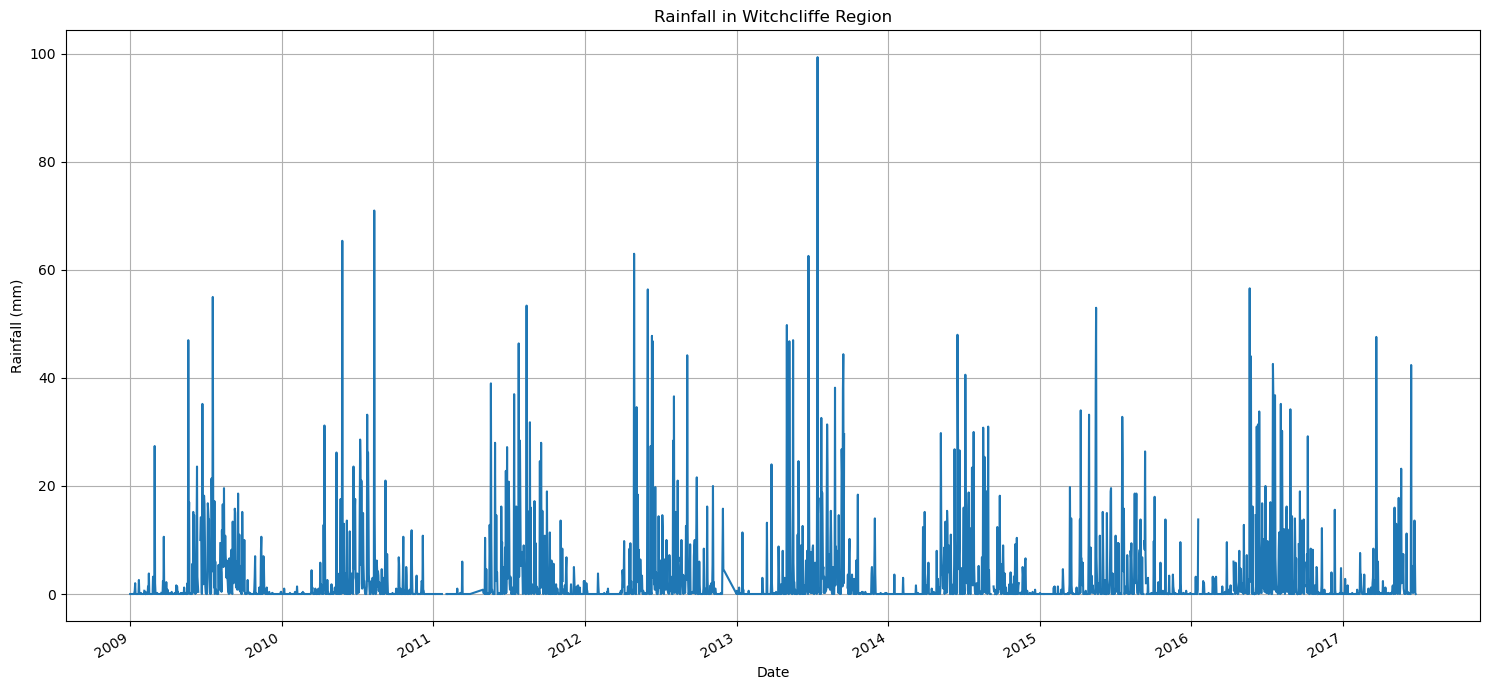

In [3]:
import matplotlib.pyplot as plt

# Plotting the rainfall data for Witchcliffe region
plt.figure(figsize=(15, 7))
witchcliffe_rainfall['Rainfall'].plot(title='Rainfall in Witchcliffe Region')
plt.ylabel('Rainfall (mm)')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
from statsmodels.tsa.stattools import adfuller

# Conduct Augmented Dickey-Fuller test
result = adfuller(witchcliffe_rainfall['Rainfall'].dropna())

# Extract and display the test statistics and p-value
adf_statistic, p_value = result[0], result[1]

adf_statistic, p_value


(-5.632753213267886, 1.0801020399530613e-06)

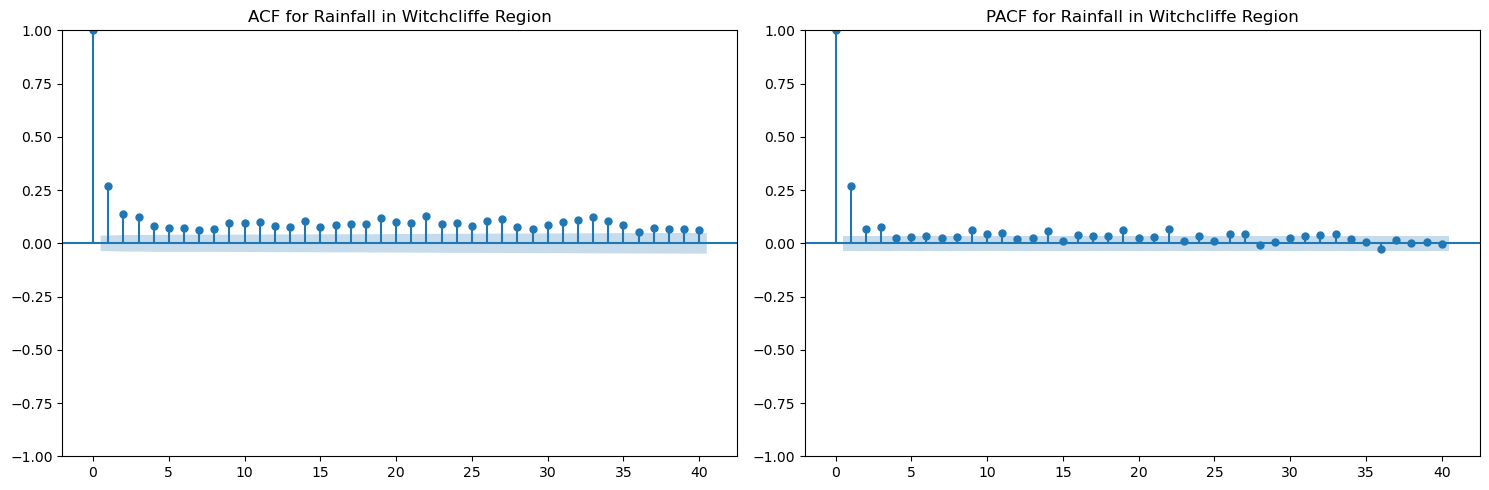

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(witchcliffe_rainfall['Rainfall'].dropna(), ax=ax[0], lags=40, title='ACF for Rainfall in Witchcliffe Region')
plot_pacf(witchcliffe_rainfall['Rainfall'].dropna(), ax=ax[1], lags=40, title='PACF for Rainfall in Witchcliffe Region')
plt.tight_layout()
plt.show()


In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Split data into training and testing sets (keeping the last 365 days for testing)
train = witchcliffe_rainfall[:-365]
test = witchcliffe_rainfall[-365:]

# Fit the SARIMAX model
model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 365))
results = model.fit(disp=False)

# Get forecast for the test set
forecast = results.get_forecast(steps=365)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Display the summary of the model
results.summary()


C:\Users\ayodh\anaconda3\envs\three-nine\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ayodh\anaconda3\envs\three-nine\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MemoryError: Unable to allocate 2.65 GiB for an array with shape (367, 367, 2645) and data type float64

In [ ]:
# Plot the actual vs forecasted values
plt.figure(figsize=(15, 7))

# Plot the training data
plt.plot(train.index, train, label='Train', color='blue')

# Plot the testing data
plt.plot(test.index, test, label='Test', color='orange')

# Plot the forecasted data
plt.plot(test.index, mean_forecast.values, label='Forecast', color='green')

# Plot the confidence intervals
plt.fill_between(test.index, 
                 confidence_intervals['lower Rainfall'], 
                 confidence_intervals['upper Rainfall'], 
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('SARIMAX Forecast vs Actuals')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.grid(True)
plt.tight_layout()
plt.show()
